# Assignment 5

## Question 1

#### Write a subroutine to solve for the inverse position kinematics for the Stanford manipulator using the discussion in Section 4.3.2 in the textbook. Plug in a few representative numerical values to compute the joint variables. Then confirm if you plug in these resulting joint variable answers with your earlier forward position kinematics code that you are indeed obtaining correct answers.

In [87]:
import numpy as np

dh_params = [
    {'theta': 0, 'd': 0, 'a': 0, 'alpha': 90},
    {'theta': 0, 'd': 0, 'a': 1, 'alpha': 0}, 
    {'theta': 0, 'd': 1, 'a': 0, 'alpha': 90}, 
]

def dh_transform(theta, d, a, alpha):
    alpha_rad = np.deg2rad(alpha)
    theta_rad = np.deg2rad(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)*np.cos(alpha_rad),  np.sin(theta_rad)*np.sin(alpha_rad), a*np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad)*np.cos(alpha_rad), -np.cos(theta_rad)*np.sin(alpha_rad), a*np.sin(theta_rad)],
        [0,                 np.sin(alpha_rad),                    np.cos(alpha_rad),                   d],
        [0,                 0,                                    0,                                  1]
    ])

def get_transformation_matrices(dh_params):
    T_matrices = []
    for params in dh_params:
        T_matrices.append(dh_transform(params['theta'], params['d'], params['a'], params['alpha']))
    return T_matrices

In [88]:
def compute_jacobian(dh_params):
    J = np.zeros((6, 3))  

    T_matrices = get_transformation_matrices(dh_params)

    end_effector_pos = T_matrices[-1][:3, 3]

    # Compute the Jacobian
    for i in range(3):
        if i < 2:
            z_axis = T_matrices[i][:3, 2] if i > 0 else np.array([0, 0, 1])
            joint_to_end_effector = end_effector_pos - T_matrices[i][:3, 3]
            J[:3, i] = np.cross(z_axis, joint_to_end_effector)
            J[3:, i] = z_axis
        else: 
            z_axis = T_matrices[i][:3, 2]
            J[:3, i] = z_axis
            J[3:, i] = np.array([0, 0, 0])

    return J

In [89]:
def inverse_kinematics_solver(end_effector_pos, dh_params):
    joint_variables = np.zeros(3)
    
    link_length = 1

    joint_variables[0] = np.arctan2(end_effector_pos[1], end_effector_pos[0])

    r = np.sqrt(end_effector_pos[0]**2 + end_effector_pos[1]**2)
    joint_variables[1] = np.arctan2(end_effector_pos[2], r - link_length)

    joint_variables[2] = np.sqrt(np.sum(np.square(end_effector_pos))) - 2 * link_length

    return joint_variables

def forward_kinematics(joint_variables, dh_params):
    T_matrices = get_transformation_matrices(dh_params)
    T_final = np.eye(4)

    for i in range(len(joint_variables)):
        theta, d = joint_variables[i], dh_params[i]['d']
        if i < 2:  
            theta += joint_variables[i]
        else:  
            d += joint_variables[i]
        T_final = np.dot(T_final, dh_transform(theta, d, dh_params[i]['a'], dh_params[i]['alpha']))

    end_effector_pos = T_final[:3, 3]
    return end_effector_pos

def test():
    desired_end_effector_pos = np.array([1, 1, 1])  
    joint_variables = inverse_kinematics_solver(desired_end_effector_pos, dh_params)
    calculated_end_effector_pos = forward_kinematics(joint_variables, dh_params)

    print("Desired End Effector Position:", desired_end_effector_pos)
    print("Calculated Joint Variables:", joint_variables)
    print("Calculated End Effector Position:", calculated_end_effector_pos)

test()


Desired End Effector Position: [1 1 1]
Calculated Joint Variables: [ 0.78539816  1.17809725 -0.26794919]
Calculated End Effector Position: [ 1.01884616 -0.70438676  0.04111176]


## Question 2

#### Write a python subroutine to calculate the joint velocities using end-effector cartesian velocities (using the discussion in Section 5.4 in the textbook). Heads up: You don’t need to write the part about calculating joint accelerations.

In [90]:
import numpy as np

def calculate_joint_velocities(jacobian, end_effector_vel):
    jacobian_pinv = np.linalg.pinv(jacobian)

    joint_velocities = np.dot(jacobian_pinv, end_effector_vel)

    return joint_velocities

jacobian_example = np.array([
    [0.5, 0, 0.2],
    [0, 0.5, 0],
    [0.2, 0, 0.5],
    [0, 0, 0],
    [0, 0, 0],
    [1, 1, 1]
])

end_effector_vel_example = np.array([1.0, 0.5, 0.2, 0.0, 0.0, 0.0])

joint_velocities = calculate_joint_velocities(jacobian_example, end_effector_vel_example)

print("Joint Velocities:", joint_velocities)


Joint Velocities: [ 1.58052434 -0.19550562 -1.08614232]


## Question 5

#### Write a python subroutine for the inverse kinematics of the spherical wrist using the discussion in Section 4.4.

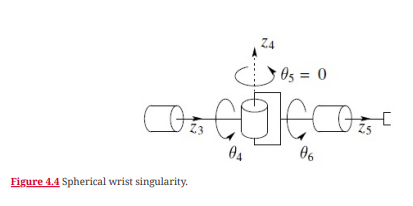

In [91]:
import numpy as np

def inverse_kinematics_spherical_wrist(R):
    epsilon = 1e-6 

    theta1, theta2, theta3 = 0, 0, 0

    if abs(R[2, 0]) > 1 - epsilon:
        theta1 = 0
        theta2 = np.arccos(R[2, 0])
        theta3 = np.arctan2(R[0, 1], R[0, 2])

        if abs(theta2) < epsilon or abs(theta2 - np.pi) < epsilon:
            print("Warning: The wrist is in or near a singularity where θ5 = 0 or π.")
    else:
        theta2 = np.arccos(R[2, 0])
        theta1 = np.arctan2(-R[2, 1], -R[2, 2])
        theta3 = np.arctan2(-R[1, 0], R[0, 0])

    return theta1, theta2, theta3

R_example = np.array([
    [0, -1, 0],
    [1,  0, 0],
    [0,  0, 1]
])

theta1, theta2, theta3 = inverse_kinematics_spherical_wrist(R_example)
print(f"Joint angles: Theta1 = {np.degrees(theta1)} degrees, Theta2 = {np.degrees(theta2)} degrees, Theta3 = {np.degrees(theta3)} degrees")


Joint angles: Theta1 = 180.0 degrees, Theta2 = 90.0 degrees, Theta3 = -90.0 degrees


Example 1 : Rotation Matrix: 180 degrees around X-axis

In [92]:
R_example_1 = np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
])
theta1, theta2, theta3 = inverse_kinematics_spherical_wrist(R_example_1)
print("Example 1 Joint Angles:", np.degrees([theta1, theta2, theta3]))

Example 1 Joint Angles: [ 0. 90.  0.]


Example 2 : Rotation Matrix: 45 degrees around Z-axis followed by 45 degrees around Y-axis

In [93]:
R_example_2 = np.array([
    [0.5, -np.sqrt(2)/2, 0.5],
    [np.sqrt(2)/2, 0.5, -np.sqrt(2)/2],
    [0.5, np.sqrt(2)/2, 0.5]
])
theta1, theta2, theta3 = inverse_kinematics_spherical_wrist(R_example_2)
print("Example 2 Joint Angles:", np.degrees([theta1, theta2, theta3]))


Example 2 Joint Angles: [-125.26438968   60.          -54.73561032]


Example 3 : 90 degrees around X-axis followed by -90 degrees around Z-axis

In [94]:
R_example_3 = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, -1]
])
theta1, theta2, theta3 = inverse_kinematics_spherical_wrist(R_example_3)
print("Example 3 Joint Angles:", np.degrees([theta1, theta2, theta3]))



Example 3 Joint Angles: [  0.  90. -90.]


## Question 6

#### Consider a 3-DOF robot of your choice (you might also consider just the first three degrees of freedom of UR5 robot used in exam 1). Complete the following tasks with this robot of your choice:

a. Write a code incorporating dynamics of the 3 DOF robot. Further,
simulate it with small initial conditions and small constant torque
values to observe the dynamic behavior (important to keep the
torques small, else the robot may be continuously accelerating).

b. Code all four versions of Independent joint control (simple, slightly
more sophisticated, feedforward, computed torque), and implement
all four versions on the dynamics code above. Pick a relatively simple
desired trajectory and some small stochastic disturbance (to be
added to the code), and test and compare the performance of all
four independent joint control methods. Document the results in
terms of plots and comparisons.

In [100]:
import numpy as np
import matplotlib.pyplot as plt


m1, m2, m3 = 1.0, 1.0, 1.0  
l1, l2, l3 = 1.0, 1.0, 1.0  
I1, I2 = 0.1, 0.1 
g = 9.81  


kp, kd, ki = 10.0, 1.0, 0.1


time_step = 0.01


def robot_dynamics(state, control_input):
 
    q1_ddot = control_input[0] / I1  
    q2_ddot = control_input[1] / I2  
    q3_ddot = control_input[2] / m3  

    q1_dot_new = state[3] + q1_ddot * time_step
    q2_dot_new = state[4] + q2_ddot * time_step
    q3_dot_new = state[5] + q3_ddot * time_step
    q1_new = state[0] + q1_dot_new * time_step
    q2_new = state[1] + q2_dot_new * time_step
    q3_new = state[2] + q3_dot_new * time_step

    return np.array([q1_new, q2_new, q3_new, q1_dot_new, q2_dot_new, q3_dot_new])

def simple_control(state, desired_state):

    error = desired_state - state[:3]
    control_input = kp * error - kd * state[3:6]
    return control_input

def sophisticated_control(state, desired_state):

    error = desired_state - state[:3]
    control_input = kp * error - kd * state[3:6]

    return control_input

def feedforward_control(state, desired_state, desired_traj):
    error = desired_state - state[:3]
    control_input = kp * error - kd * state[3:6] + desired_traj
    return control_input

def computed_torque_control(state, desired_state):
    q1, q2, q3, q1_dot, q2_dot, q3_dot = state
    q1_des, q2_des, q3_des = desired_state

    error = np.array([q1_des - q1, q2_des - q2, q3_des - q3])
    error_dot = np.array([-q1_dot, -q2_dot, -q3_dot])  

    M = np.array([[I1, 0, 0],
                  [0, I2, 0],
                  [0, 0, 1]]) 

    C = np.zeros(3)

    G = np.array([0, m2 * g * l2 * np.cos(q2), m3 * g])

    control_input = np.linalg.inv(M) @ (kp * error + kd * error_dot + G + C)
    return control_input

def desired_trajectory(time):
    q1_desired = np.sin(time)
    q2_desired = np.cos(time)
    q3_desired = np.sin(time) / 2
    return np.array([q1_desired, q2_desired, q3_desired])

def simulate_robot(control_method, num_steps, time_step):
    state = np.array([0, 0, 0, 0, 0, 0])

    states = []

    for step in range(num_steps):
        time = step * time_step
        desired_state = desired_trajectory(time)

        if control_method == feedforward_control:
            control_input = control_method(state, desired_state, desired_trajectory(time))
        else:
            control_input = control_method(state, desired_state)

        state = robot_dynamics(state, control_input)
        states.append(state)

    return np.array(states)

num_steps = 1000
simple_states = simulate_robot(simple_control, num_steps, time_step)
sophisticated_states = simulate_robot(sophisticated_control, num_steps, time_step)
feedforward_states = simulate_robot(feedforward_control, num_steps, time_step)
computed_torque_states = simulate_robot(computed_torque_control, num_steps, time_step)


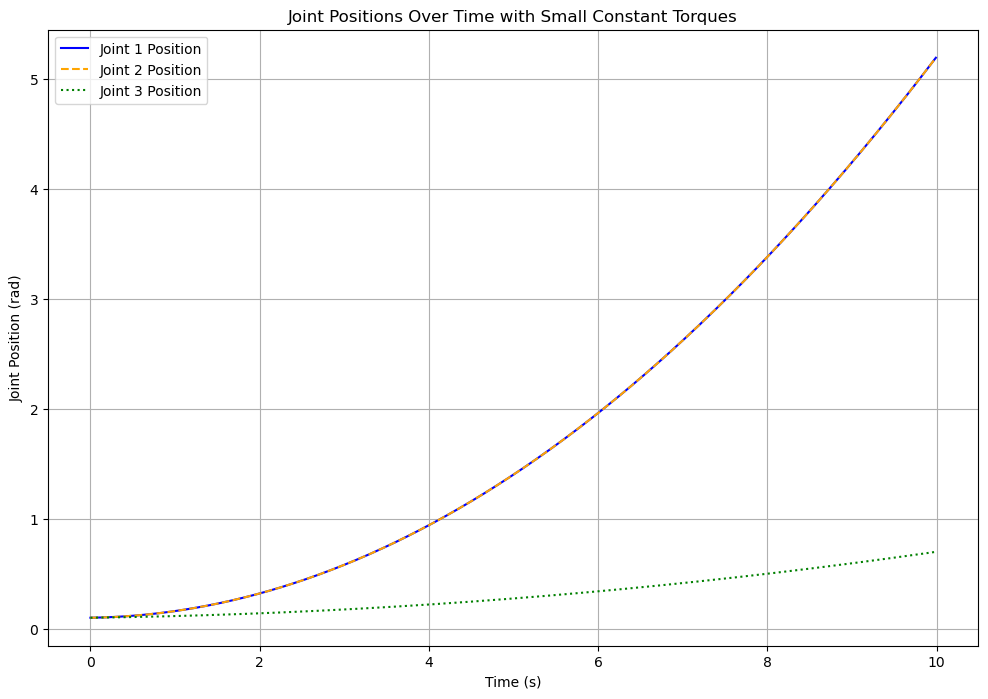

In [96]:
initial_state = np.array([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])

constant_torques = np.array([0.01, 0.01, 0.01])

time_step = 0.01
num_steps = 1000

state_history = np.zeros((num_steps, len(initial_state)))
state_history[0, :] = initial_state

for step in range(1, num_steps):
    previous_state = state_history[step - 1, :]
    
    new_state = robot_dynamics(previous_state, constant_torques)
    
    state_history[step, :] = new_state

time = np.arange(num_steps) * time_step
plt.figure(figsize=(12, 8))
plt.plot(time, state_history[:, 0], label='Joint 1 Position', linestyle='-', color='blue')  # Solid line for Joint 1
plt.plot(time, state_history[:, 1], label='Joint 2 Position', linestyle='--', color='orange')  # Dashed line for Joint 2
plt.plot(time, state_history[:, 2], label='Joint 3 Position', linestyle=':', color='green')  # Dotted line for Joint 3
plt.xlabel('Time (s)')
plt.ylabel('Joint Position (rad)')
plt.title('Joint Positions Over Time with Small Constant Torques')
plt.legend()
plt.grid(True)
plt.show()


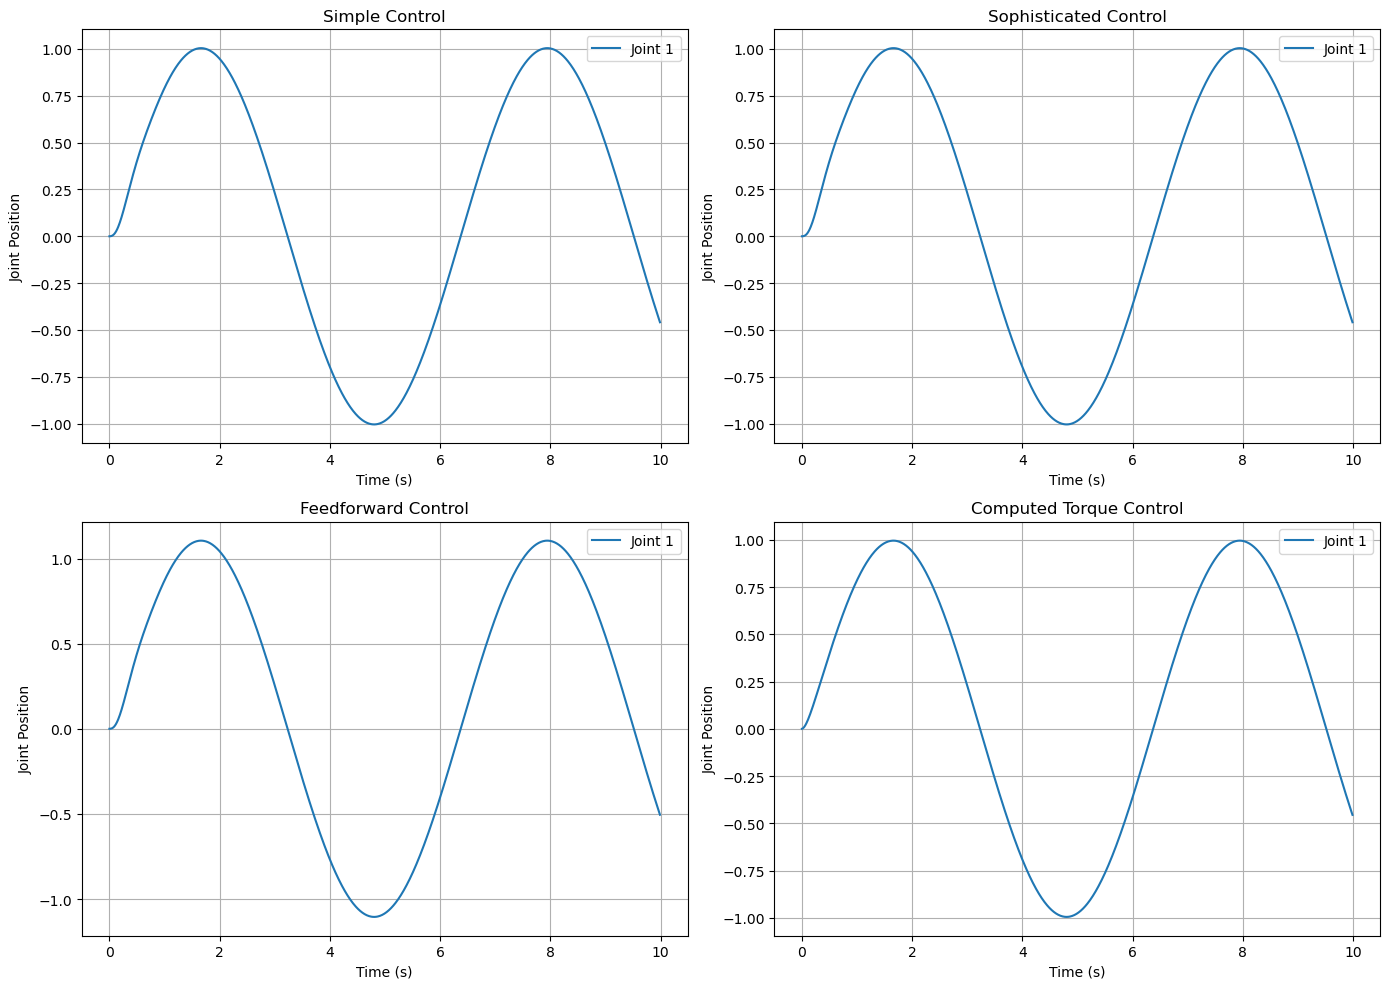

In [97]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(time, simple_states[:, 0], label='Joint 1')
plt.xlabel('Time (s)')
plt.ylabel('Joint Position')
plt.title('Simple Control')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(time, sophisticated_states[:, 0], label='Joint 1')
plt.xlabel('Time (s)')
plt.ylabel('Joint Position')
plt.title('Sophisticated Control')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(time, feedforward_states[:, 0], label='Joint 1')
plt.xlabel('Time (s)')
plt.ylabel('Joint Position')
plt.title('Feedforward Control')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(time, computed_torque_states[:, 0], label='Joint 1')
plt.xlabel('Time (s)')
plt.ylabel('Joint Position')
plt.title('Computed Torque Control')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

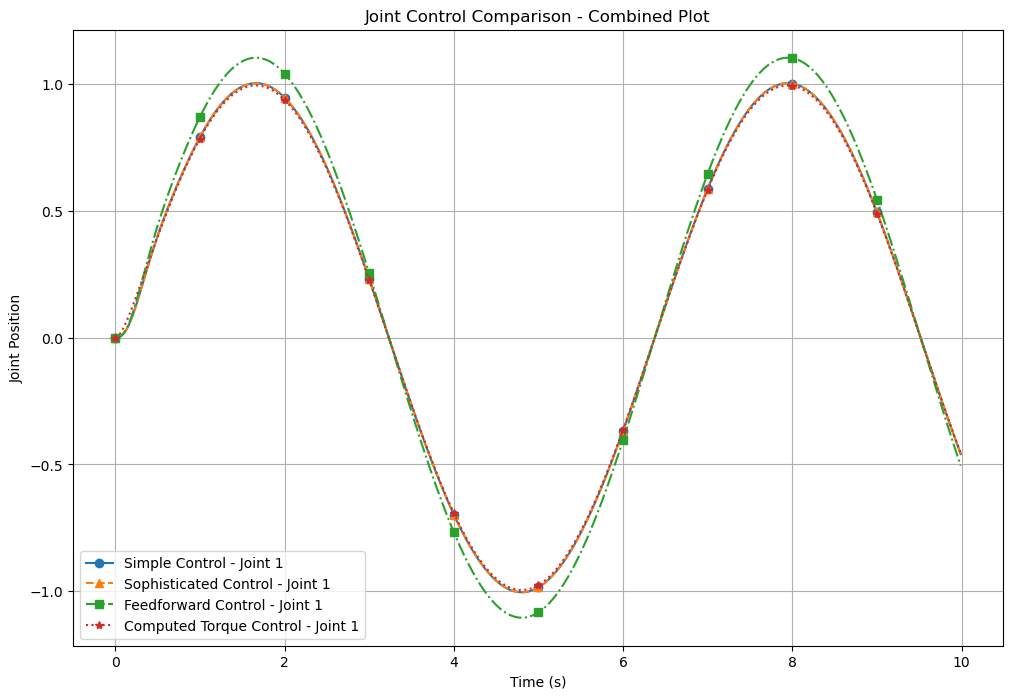

In [99]:
plt.figure(figsize=(12, 8))

plt.plot(time, simple_states[:, 0], label='Simple Control - Joint 1', linestyle='-', marker='o', markevery=100)

plt.plot(time, sophisticated_states[:, 0], label='Sophisticated Control - Joint 1', linestyle='--', marker='^', markevery=100)

plt.plot(time, feedforward_states[:, 0], label='Feedforward Control - Joint 1', linestyle='-.', marker='s', markevery=100)

plt.plot(time, computed_torque_states[:, 0], label='Computed Torque Control - Joint 1', linestyle=':', marker='*', markevery=100)

plt.xlabel('Time (s)')
plt.ylabel('Joint Position')
plt.title('Joint Control Comparison - Combined Plot')
plt.legend()
plt.grid(True)
plt.show()
